In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import word2vec
import re 

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm
from itertools import chain


C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
!pip install spacy

In [3]:
!pip install nltk

In [4]:
!pip install word2vec

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 


nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arturo.reyeslopez\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
# From https://dictionary.cambridge.org/grammar/british-grammar/word-formation/prefixes
english_prefixes = {
"anti": "",    # e.g. anti-goverment, anti-racist, anti-war
"auto": "",    # e.g. autobiography, automobile
"bio": "",     # e.g. life, living matter
#"de": "",      # e.g. de-classify, decontaminate, demotivate
#"dis": "",     # e.g. disagree, displeasure, disqualify
"down": "",    # e.g. downgrade, downhearted
"extra": "",   # e.g. extraordinary, extraterrestrial
"hyper": "",   # e.g. hyperactive, hypertension
#"il": "",     # e.g. illegal
#"im": "",     # e.g. impossible
#"in": "",     # e.g. insecure
#"ir": "",     # e.g. irregular
#"inter": "",  # e.g. interactive, international
"mega": "",   # e.g. megabyte, mega-deal, megaton
#"mid": "",    # e.g. midday, midnight, mid-October
#"mis": "",    # e.g. misaligned, mislead, misspelt
"non": "",    # e.g. non-payment, non-smoking
"over": "",  # e.g. overcook, overcharge, overrate
"out": "",    # e.g. outdo, out-perform, outrun
"post": "",   # e.g. post-election, post-warn
"pre": "",    # e.g. prehistoric, pre-war
#"pro": "",    # e.g. pro-communist, pro-democracy
#"re": "",     # e.g. reconsider, redo, rewrite
"semi": "",   # e.g. semicircle, semi-retired
#"sub": "",    # e.g. submarine, sub-Saharan
"super": "",   # e.g. super-hero, supermodel
"tele": "",    # e.g. television, telephathic
"trans": "",   # e.g. transatlantic, transfer
"ultra": "",   # e.g. ultra-compact, ultrasound
#"un": "",      # e.g. under-cook, underestimate
#"up": "",      # e.g. upgrade, uphill
}

In [7]:
import re
from nltk.stem import PorterStemmer
porter = PorterStemmer()

In [8]:
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]

    close_words = model.similar_by_word(word)

    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [9]:
##Get average sentence vector
def avg_sentence_vector(words, model, num_features, index2word_set):
    #function to average all words vectors in a given paragraph
    featureVec = np.zeros((num_features,), dtype="float32")
    nwords = 0
    for word in words:
        if any(word in s for s in index2word_set):
            nwords = nwords+1
            featureVec = np.add(featureVec, model[word])

    if nwords>0:
        featureVec = np.divide(featureVec, nwords)
    
    return featureVec

In [10]:
def change_string(str):
    str = re.sub(r'(\w{2}\s)?\s?& (\w{2})?',r'\1\2',str).lower() #Remove & and put together letters divided by &
    str = str.replace(".com","") #Remove .com
    str = str.replace("'s", "")
    str = re.sub(r'[^\w\s]',' ',str) #Remove symbols
    str = re.sub(r'\b([a-z])\s+(?=[a-z]\b)', r'\1', str) #Remove spaces between two characters
    str =re.sub(r"\b[a-zA-Z]\b", "", str)#Remove single characters
    str =re.sub(r"[ ]{2,}", " ",str); #Remove more than one space between words

    return str.upper()

In [11]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arturo.reyeslopez\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def additional_stops(file):
    stopList=[]
    stopList=[line.strip() for line in open(file, 'r')]
    stopWord= [[word.lower() for word in text.split()] for text in stopList]
    
    return set(stopList)

In [13]:
#Flatten one level of nesting
def flatten(listOfLists):
    return list(chain.from_iterable(listOfLists))

In [14]:
def listOfLists(lst):
    return list(map(lambda el:[el], lst)) 

In [15]:
#Recives a list of words
#Returns a list of prefixes and steam words
def stem_prefix(company, prefixes):
    comp=[]
    company = list(filter(None, company))
    for word in company:
        for prefix in sorted(prefixes, key=len, reverse=True):
            # Use subn to track the no. of substitution made.
            # Allow dash in between prefix and root. 
            word, nsub = re.subn("{}[\-]?".format(prefix), "", word)
            if nsub > 0:
                comp.append(prefix)
        comp.append(porter.stem(word))
    return comp

In [16]:
#Receives a list of words
#Returns a list of prefixes and list of steam words
def porter_english_plus(companiesList, prefixes=english_prefixes):
    coList=[]
    
    for company in companiesList:
        coList.append(stem_prefix(company.split(" "), prefixes))
    
    return coList

In [17]:
#Search new words to compare against the dataset are included in the vocabulary. 
#Otherwise, Include them to calculate vectors
def searchVocab(words):
    vocab=[]
    for word in words:
        try:
            word2vec_model[word]
        except:
            vocab.append(word)
    return vocab

In [18]:
import word2vec

In [19]:
def preprocessing(words):
    stopWords = additional_stops('data/stop-words.txt')

    tokens=list(map(lambda x: change_string(x),list(map(lambda x: ' '.join([word for word in x.split() if word.lower() not in stopWords]), words))))
    
    toks= porter_english_plus(tokens)
    
    ps = PorterStemmer()
    
    return list(map(lambda x: [ps.stem(y) for y in x], toks))

In [20]:
#Read dataset:
def readFileToDataFrame(fileName):
    return pd.read_csv(fileName, usecols = ['name'])


In [21]:
#Process dataset sent as dataframe:
def preprocess(df):
    words=[]
    
    words= df['name'].values.tolist()
    
    prepWords= preprocessing(words)
        
    data_transposed = zip(prepWords)
    df  = pd.DataFrame(data_transposed, columns=["name"])
    df2 = df['name']
    
    return prepWords, df2

In [22]:
def trainModel(prepWords):
    prepWords=flatten(prepWords)
    
    prepWords= [i for i in prepWords if i] 
    
    prepWords= [[el] for el in prepWords]
    
    #Training model using preprocessed data
    #size: Dinmensionality of the word vectors
    #window: Maximum distance between the current and predicted word within a sentence
    #min_count: Ignores all words with total frequency lower than this.
    #workers: Use these many worker threads to train the model
    #sg: The training algorithm, either CBOW(0) or skip gram(1). Default is 0s
    word2vec_model = Word2Vec(prepWords,size=300, window=2, min_count=1, workers=7, sg=1)

    #Summarize vocabulary
    words = list(word2vec_model.wv.vocab)
    
    return word2vec_model

In [23]:
df= readFileToDataFrame('name-submission-sample.csv')

col_names =  ['name', 'avg_vector']
df2 = pd.DataFrame(col_names)

prepWords, df2= preprocess(df)

word2vec_model= trainModel(prepWords)

df['avg_vector']=df2.apply(lambda row : avg_sentence_vector(row, model=word2vec_model, num_features=300, index2word_set=set(word2vec_model.wv.index2word)).tolist())

##Saving name and vector values in file
df.to_csv('name-submission-vectors.csv',encoding='utf-8', index=False)

words = list(word2vec_model.wv.vocab)

C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [24]:
from scipy import spatial
from gensim.models import KeyedVectors

#ORIGINAL 4 PAWS ONLY PET SERVICE
#get average vector for a new company
#company = "SMOKERY-FLURER" #1.0
#company = "PAWS 4 PET SERVICE" #Google:0.95, Word2Vec model:  1.0
#company = "PAWS FOR ONLY PET" #0.80 0.77193
#company = "PAWS FOR ONLY PETS" #0.80 0.77193, 0.738519, 0.721
#company = "POS FOR PET" #POS is not in the vocabulary, 0.5495
#company ="VICTORIA INSTITUTE BIO CHEMICAL" #1.0 VICTORIA INSTITUTE BIOCHEMICAL
#company ="VICTORIA INSTITUTE'S BIO-CHEMICAL"
company = "AIR TWO RENTAL SOLUTIONS" #0.745764, 0.764062 -sg:skip-gram, size:300, 0.80348

#company= "FALLEN TRACTOR SERVICES"#0.701912

words=[]
words.append(company)

prepWords= preprocessing(words)

#Before query words in vocabulary and returns the words needed to be included in the vocabulary
prepWords=flatten(prepWords)

prepWords=[i for i in prepWords if i] 

vocab= searchVocab(prepWords)

#If needed add word to vocabulary
if len(vocab) > 0:
    pwords=[]
    df= readFileToDataFrame('name-submission-sample.csv')
    pwords, df2= preprocess(df)
    pwords.append(vocab)
    word2vec_model= trainModel(pwords)    
    #Calculating average vector for each company name:
    df['avg_vector']=df2.apply(lambda row : avg_sentence_vector(row, model=word2vec_model, num_features=300, index2word_set=set(word2vec_model.wv.index2word)).tolist())
    #Saving name and vector values in file
    df.to_csv('name-submission-vectors.csv',encoding='utf-8', index=False)

df = pd.read_csv('name-submission-vectors.csv', usecols = ['name','avg_vector'])
df['avg_vector']=df['avg_vector'].apply(lambda s: [float(x.strip(' []')) for x in s.split(',')])

company_avg_vector = avg_sentence_vector(prepWords, model=word2vec_model, num_features=300, index2word_set=set(word2vec_model.wv.index2word))

df['similarity']=df['avg_vector'].apply(lambda row : 1 - spatial.distance.cosine(row, company_avg_vector))

s= df['similarity'].max()
print("Similarity:",s)

df3= df.loc[df['similarity']== s]
print(df3)


C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


Similarity: 0.7492349584018971
                         name  \
200  AIR ONE RENTAL SOLUTIONS   

                                            avg_vector  similarity  
200  [-0.0006513572297990322, 0.0003201732179149985...    0.749235  


C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [25]:
#print(word2vec_model['victoria'])

In [26]:
ms=word2vec_model.most_similar('pet')

for x in ms:
    print (x)

C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


('fastfood', 0.20879755914211273)
('hammer', 0.20450574159622192)
('allur', 0.20118337869644165)
('wright', 0.20001833140850067)
('daili', 0.1990675926208496)
('mgt', 0.1908089816570282)
('mcintosh', 0.18571510910987854)
('autopart', 0.1729743778705597)
('metamorphosi', 0.16965581476688385)
('doak', 0.16890916228294373)


In [27]:
print (word2vec_model.similar_by_word('paw', 2)) # Get two most similar words to 'paw'

[('technolog', 0.20126648247241974), ('hummel', 0.18740878999233246)]


C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


In [28]:
words = list(word2vec_model.wv.vocab)
print(words)

['rfn', 'contract', 'splash', 'beauti', 'studio', 'fabl', 'clean', 'mainland', 'tank', 'servic', 'harrison', 'develop', 'strate', 'scape', 'tight', 'line', 'fish', 'charter', 'westwat', 'thechimneyguy', 'chimney', '2008', 'enterpri', 'cottonwood', 'tree', 'emporium', 'westform', 'kevin', 'mitchel', 'construct', 'interior', 'drywood', 'initi', 'elip', 'consult', 'coal', 'valley', 'metal', 'recycl', 'greenwood', 'gourmet', 'mushroom', 'BC', 'blacklin', 'form', 'chida', 'technolog', 'ward', 'group', 'health', 'system', 'strategi', 'okonlin', 'info', 'softwar', 'LO', 'dare', 'RZ', 'excav', 'log', 'DJ', 'product', 'sabiston', 'builder', 'uniqu', 'you', 'integr', 'well', 'ladner', 'storag', 'real', 'time', 'graphic', 'wrap', 'IT', 'UP', 'insul', 'market', 'MC', 'mainten', 'new', 'view', 'yaskar', 'sea', 'marin', 'electr', 'octan', 'help', 'hand', 'senior', 'care', 'mediar', 'dvd', 'canada', 'camprv', 'rental', 'alemb', 'heal', 'art', 'centr', 'ET', 'transport', 'abm', 'drywal', 'committ', 's

C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\arturo.reyeslopez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


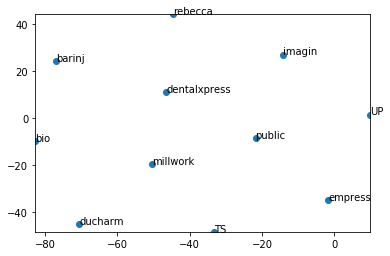

In [30]:
display_closestwords_tsnescatterplot(word2vec_model, 'bio', 300)
